In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import seaborn as sns

import pandas as pd
from sklearn import cluster, datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torch.nn.functional as Func
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split

In [2]:
# Load data
f = pd.read_csv("data.csv")
f.rename(columns={'time sample band g': 'time_g', 'time sample band r': 'time_r',
                    'time sample band i': 'time_i','total flux + noise band g': 'tfnbg',
                    'total flux + noise band r': 'tfnbr', 'total flux + noise band i': 'tfnbi',}, inplace=True)

def standard(dataset):
    
    scaler = MinMaxScaler(feature_range = (0, 1), copy=False)
    #scaler = StandardScaler()
    
    df = 0
    dfbis = 0
    for ide, group in dataset.groupby('ID'):

        a = dataset[dataset.ID == ide]
        c = a[['ID', 'images']]
        data = a[a.columns[2:]].copy()
        t = ['time_g', 'time_r', 'time_i']
        
        data[['tfnbg', 'tfnbr', 'tfnbi']] = scaler.fit_transform(data[['tfnbg', 'tfnbr', 'tfnbi']])
        data[t] = data[t]-np.min(data[t])

        if ide == 0:
            df = pd.concat([c, data], axis=1)
        else:
            dfbis = pd.concat([c, data], axis = 1)
            df = pd.concat([df, dfbis])

    return df

In [3]:
f['images'] = f['images'].replace([1, 2, 3, 4], [0, 1, 1, 1])

In [4]:
train = f[:91*8000]
val = f[91*8000:91*9000]
test = f[91*9000:]

In [5]:
print((train['images']==0).sum())
print((train['images']==1).sum())


print((test['images']==0).sum())
print((test['images']==1).sum())

359541
368459
45591
45409


In [6]:
def dataframe_to_dataset(f):
        
    scaler = MinMaxScaler(feature_range = (0, 1), copy=False)
    #scaler = StandardScaler()

    features_columns = f.columns.tolist()[2:]
    T = []
    F = []
    
    for ide, group in f.groupby('ID'):

        a = f[f.ID == ide]
        c = a[['ID', 'images']]
        data = a.copy()
        t = ['time_g', 'time_r', 'time_i']
        
        data[['tfnbg', 'tfnbr', 'tfnbi']] = scaler.fit_transform(data[['tfnbg', 'tfnbr', 'tfnbi']])
        data[t] = data[t]-np.min(data[t])

        T.append(a['images'].values[0])
        F.append(torch.tensor(data[features_columns].T.values)[..., None])

    
    T = torch.tensor(T)
    F = torch.cat(F, dim=-1)
    print(F.shape)
    return TensorDataset(F.T.double(), T.double())

In [7]:
TrainSet = dataframe_to_dataset(train)
TestSet = dataframe_to_dataset(test)
ValSet = dataframe_to_dataset(val)

torch.Size([6, 91, 8000])


/var/folders/wj/f1k4v84n75vfsjmdsxm0kfxh0000gn/T/ipykernel_19852/4085115565.py:27: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/TensorShape.cpp:2318.)
  return TensorDataset(F.T.double(), T.double())


torch.Size([6, 91, 1000])
torch.Size([6, 91, 1000])


In [8]:
TrainSet

In [9]:
class SequenceModel(nn.Module):
    
    def __init__(self, n_channels, n_classes, n_hidden=64):
        
        super().__init__()
        
        #self.lstm1 = nn.Conv1d(
        #in_channels = n_features,
        #out_channels = n_hidden,
        #kernel_size = 5)
        self.lstm1 = nn.LSTM(
            input_size = n_channels,
            hidden_size = n_hidden,
            num_layers = 5) 
        
        #self.lstm2 = nn.Conv1d(
        #in_channels = n_hidden,
        #out_channels = 128,
        #kernel_size = 5)
        
        
        self.c1 = nn.Linear(64*91, 512)
        self.c2 = nn.Linear(512, n_classes-1)
            
        
    def forward(self, x):
        x, (ht, ct) = self.lstm1(x) 
        #x = Func.relu(self.lstm1(x))
        #x = self.lstm1(x)
        x = torch.flatten(x, 1)
        x= self.c1(x)
        pred = self.c2(x)
        pred = torch.sigmoid(pred)
        return pred
        

In [10]:
torch.manual_seed(0)

In [11]:
model = SequenceModel(n_channels = 6, 
                        n_classes = 2)
model = model.double()

In [12]:
print(model)

SequenceModel(
  (lstm1): LSTM(6, 64, num_layers=5)
  (c1): Linear(in_features=5824, out_features=512, bias=True)
  (c2): Linear(in_features=512, out_features=1, bias=True)
)


In [13]:
TrainLoader = data_utils.DataLoader(TrainSet, batch_size = 16, shuffle = True)
ValLoader = data_utils.DataLoader(ValSet, batch_size = 16, shuffle = False)
TestLoader = data_utils.DataLoader(TestSet, batch_size = 16, shuffle = False)

In [14]:
loss_function = torch.nn.BCEWithLogitsLoss()

In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [16]:
print("--- State_dict du model : ---")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())
print()

--- State_dict du model : ---
lstm1.weight_ih_l0 	 torch.Size([256, 6])
lstm1.weight_hh_l0 	 torch.Size([256, 64])
lstm1.bias_ih_l0 	 torch.Size([256])
lstm1.bias_hh_l0 	 torch.Size([256])
lstm1.weight_ih_l1 	 torch.Size([256, 64])
lstm1.weight_hh_l1 	 torch.Size([256, 64])
lstm1.bias_ih_l1 	 torch.Size([256])
lstm1.bias_hh_l1 	 torch.Size([256])
lstm1.weight_ih_l2 	 torch.Size([256, 64])
lstm1.weight_hh_l2 	 torch.Size([256, 64])
lstm1.bias_ih_l2 	 torch.Size([256])
lstm1.bias_hh_l2 	 torch.Size([256])
lstm1.weight_ih_l3 	 torch.Size([256, 64])
lstm1.weight_hh_l3 	 torch.Size([256, 64])
lstm1.bias_ih_l3 	 torch.Size([256])
lstm1.bias_hh_l3 	 torch.Size([256])
lstm1.weight_ih_l4 	 torch.Size([256, 64])
lstm1.weight_hh_l4 	 torch.Size([256, 64])
lstm1.bias_ih_l4 	 torch.Size([256])
lstm1.bias_hh_l4 	 torch.Size([256])
c1.weight 	 torch.Size([512, 5824])
c1.bias 	 torch.Size([512])
c2.weight 	 torch.Size([1, 512])
c2.bias 	 torch.Size([1])



In [17]:
losses = []  
N_epochs = 5

for epoch in range(N_epochs):  # Loop over epochs
    
    for features, label in TrainLoader:
        #print(features.shape)
        # Erase previous gradients
        optimizer.zero_grad()
        
        #print(features.shape)
        labels_pred =[]
        # Forward Propagation 
        labels_pred = model(features)  
        #print(labels_pred.shape)
        
        #print(labels_pred)
        #label = tensor(np.array(label[0].item()))   # for size 2 in output of the model
        #label = torch.tensor([label[0].item()]).to(torch.float)
        
        
        # Loss computation
        loss = loss_function(labels_pred, label[..., None])
        #val_loss = loss_function(labels_val_pred, labels_val)
        # Save loss for future analysis
        losses.append(loss.item())
        #val_losses.append(val_loss)
        


        
        # Compute gradients (backpropagation)
        loss.backward()
        
        # Weight update
        optimizer.step()

    print('Training done')

Training done
Training done
Training done
Training done
Training done


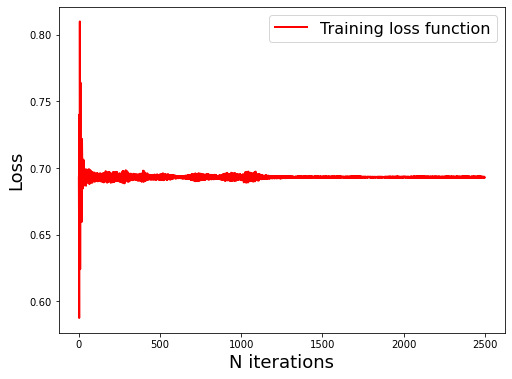

In [18]:
# Display loss evolution
fig, axes = plt.subplots(figsize=(8,6))
axes.plot(losses,'r-',lw=2,label='Training loss function')
#axes.plot(val_losses,'b-',lw=2,label='Validation loss function')
axes.set_xlabel('N iterations',fontsize=18)
axes.set_ylabel('Loss',fontsize=18)
#plt.ylim([0, 1])
plt.legend(loc='upper right',fontsize=16)

In [19]:
val_losses = []
for epoch in range(N_epochs):  # Loop over epochs
    running_loss = 0.0
   
    for features, labels in ValLoader:
        
        # Forward Propagation 
        labels_pred = model(features.float())
        label = torch.tensor([labels[0].item()]).to(torch.float)

        # Loss computation
        loss = loss_function(labels_pred, label)

        # Save loss for future analysis
        val_losses.append(loss.item())
        
    print('Training done')

RuntimeError: expected scalar type Float but found Double

In [ ]:
# Accuracy
def accuracy(model,dataloader):
    correct = 0
    total = 0
    # No need to compute gradients here
    with torch.no_grad():
        for features, labels in dataloader:
            print(len(labels))
            # Forward propagation to get predictions
            pred = model(features.float()) 
            otherprob = 1 - pred.item()           
            outputs = torch.tensor([[pred, otherprob]])
            labels = torch.tensor([labels[0].item()]).to(torch.float)
            print(labels)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            #print(total)
            correct += (predicted == labels).sum().item()
    return 100.0 * correct / total       

print('Accuracy : %.2f %%' % (accuracy(model,TestLoader)))   